Universidad del Valle de Guatemala <br>
Facultad de Ingeniería <br>
Departamento de Ciencias de la Computación <br>
Deep Learning <br>

# Laboratorio 10

Integrantes
- Gabriel Vicente
- Christopher García
- Marco Orozco
- Rodrigo Barrera
- Isabel Solano

Instrucciones:
- Deben estar unido a uno de los grupos de Canvas de nombre “Laboratorio 9,10 # - N”, donde N es un número entre 1 y 15. Los grupos pueden ser de máximo 5 personas.
- Esta actividad debe realizarse en grupos.
- Sólo es necesario que una persona del grupo suba el trabajo a Canvas.
- No se permitirá ni se aceptará cualquier indicio de copia. De presentarse, se procederá según el reglamento correspondiente.

## Task 1 - Práctica
Para esta parte estarán resolviendo el problema de CartPole con Deep Q-Learning y una red de destino. Para esto, el objetivo de este ejercicio es entrenar a un agente para que equilibre un poste en un carro (cartpole) en movimiento
durante el mayor tiempo posible. Se deberá usar Deep Q-Learning (DQL) con una red objetivo para lograr esto. Para realizar este ejercicio necesitará:
1. Python con las bibliotecas necesarias, incluidas Gymnasium, NumPy y PyTorch (para este caso, pueden usar otro framework de Deep Learning si no se sienten cómodos con PyTorch).
2. El entorno CartPole proporcionado por Gymnasium.


Considere las siguientes instrucciones generales para realizar este ejercicio:

### 1. Liberías
Asegúrese de tener instalado Gymnasium, NumPy y el framework de Deep Learning que haya
elegido.

In [2]:
import random
import numpy as np
import tensorflow as tf
import gymnasium as gym
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt


### 2. Cree el entorno CartPole
Utilice la biblioteca Gymnasium para crear el entorno CartPole. Este entorno simula la tarea de equilibrar un poste en un carro en movimiento.

In [3]:
env = gym.make('CartPole-v1', render_mode = 'human')


### 3. Defina las redes en línea y de destino
Cree dos redes neuronales, la red en línea y la red de destino. La red en línea se utiliza para la selección de acciones y se actualiza con más frecuencia, mientras que la red de destino se utiliza para estimar los valores Q y se actualiza periódicamente. Ambas redes deberían tener una arquitectura similar con capas de entrada y salida. Inicialmente, la red de destino debería tener los mismos pesos que la red en línea

In [4]:
# 1. Definir las redes en línea y de destino
input_shape = env.observation_space.shape[0]
num_actions = env.action_space.n


# Red en línea
online_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_actions, activation='linear')
])

# Red de destino (inicialmente con los mismos pesos que la red en línea)
target_model = keras.models.clone_model(online_model)

# Compilar ambas redes
online_model.compile(optimizer='adam', loss='mean_squared_error')
target_model.compile(optimizer='adam', loss='mean_squared_error')

### 4. Establecer hiperparámetros
Defina hiperparámetros como el número de episodios, el tamaño de los batches, el factor de descuento (gamma) y los parámetros de exploración (epsilon, epsilon decay, epsilon mínimo). Ajuste estos hiperparámetros según sea necesario para optimizar el entrenamiento.

In [5]:
# 2. Establecer hiperparámetros
num_episodes = 100

batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
target_update_frequency = 10

### 5. Defina la selección de acciones épsilon-greedy
Cree una función para la selección de acciones
épsilon-greedy. Esta función ayuda al agente a elegir acciones basadas en la política épsilon-greedy

In [6]:
# 3. Definir la selección de acciones épsilon-greedy
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        q_values = online_model.predict(state)
        return np.argmax(q_values)


### 6. Defina la reproducción de la experiencia (experience replay)
Implemente una función para la
reproducción de la experiencia, que es una parte crucial de DQL. Esta función ayuda al agente a aprender
de una memoria de repetición y a estabilizar el entrenamiento.

In [7]:
# 4. Definir la reproducción de la experiencia
experience_replay = deque(maxlen=10000)

def experience_replay_sample(batch_size):
    samples = random.sample(experience_replay, batch_size)
    states, actions, rewards, next_states, dones = zip(*samples)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


### 7. Ciclo de entrenamiento
Cree un ciclo para el entrenamiento del agente. En cada episodio, el agente
interactúa con el entorno, recopila experiencias y actualiza sus valores Q mediante la repetición de
experiencias (experience replay). La red de destino se actualiza cada N episodios.

### 8. Representar el entorno
Para visualizar el progreso del entrenamiento del agente, use env.render() para
mostrar el entorno CartPole durante el entrenamiento. Asegúrese de llamar a env.close() al final para
limpiar el renderizado.

![Laboratorio 10](Laboratorio10.gif)

In [8]:

episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()

    state, _ = state


    state = np.array(state, dtype=np.float32) 
    state = state.reshape((1, -1))

    total_reward = 0
    done = False
    state_count = 0

    while not done:

        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, input_shape])
        total_reward += reward

        experience_replay.append((state, action, reward, next_state, done))

        state = next_state

        if len(experience_replay) >= batch_size:
            states, actions, rewards, next_states, dones = experience_replay_sample(batch_size)

            states = np.vstack(states)

            target_values = online_model.predict(states)

            next_states = np.vstack(next_states)

            target_next_values = target_model.predict(next_states)
            max_target_values = np.max(target_next_values, axis=1)

            for i in range(batch_size):
                if dones[i]:
                    target_values[i][actions[i]] = rewards[i]
                else:
                    target_values[i][actions[i]] = rewards[i] + gamma * max_target_values[i]

            online_model.fit(states, target_values, epochs=1, verbose=0)

        if episode % target_update_frequency == 0:
            target_model.set_weights(online_model.get_weights())

    if epsilon > epsilon_min:
        print("im in")
        epsilon *= epsilon_decay

    print(f"Episode {episode}: Total Reward: {total_reward}")
    episode_rewards.append(total_reward)

env.close()

im in
Episode 0: Total Reward: 28.0
im in
Episode 1: Total Reward: 12.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 2: Total Reward: 44.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 3: Total Reward: 33.0
2/2 [==============================] - 0s 993us/step
im in
Episode 4: Total Reward: 19.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 5: Total Reward: 38.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 6: Total Reward: 10.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 7: Total Reward: 31.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 8: Total Reward: 22.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 9: Total Reward: 28.0
2/2 [==============================] - 0s 3ms/step
im in
Episode 10: Total Reward: 24.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 11: Total Reward: 32.0
2/2 [==============================] - 0s 1ms/step
im 

### 9. Supervisar el entrenamiento
Supervise el progreso del entrenamiento del agente, incluida la recompensa
total obtenida en cada episodio, para esto utilice una gráfica

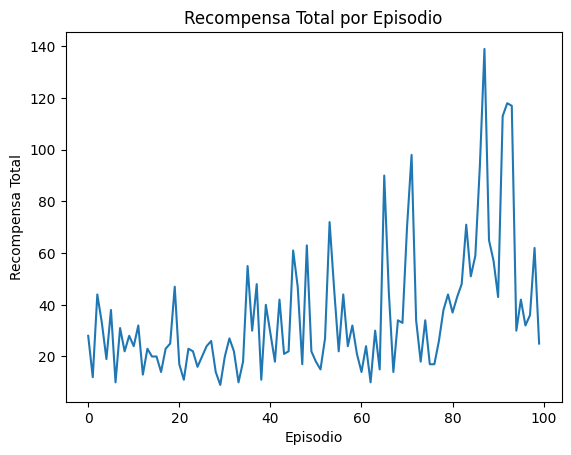

In [9]:
plt.plot(episode_rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Recompensa Total por Episodio")
plt.show()


### 10. Evalúe el rendimiento
Una vez que se complete el entrenamiento, evalúe el rendimiento del agente
probándolo en el entorno CartPole sin renderizar y observe qué tan bien puede equilibrar el poste.

2/2 [==============================] - 0s 2ms/step
im in
Episode 0: Total Reward: 28.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 1: Total Reward: 40.0
2/2 [==============================] - 0s 3ms/step
im in
Episode 2: Total Reward: 35.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 3: Total Reward: 23.0
2/2 [==============================] - 0s 991us/step
im in
Episode 4: Total Reward: 27.0
2/2 [==============================] - 0s 3ms/step
im in
Episode 5: Total Reward: 42.0
2/2 [==============================] - 0s 3ms/step
im in
Episode 6: Total Reward: 53.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 7: Total Reward: 18.0
2/2 [==============================] - 0s 1ms/step
im in
Episode 8: Total Reward: 30.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 9: Total Reward: 16.0
2/2 [==============================] - 0s 2ms/step
im in
Episode 10: Total Reward: 17.0
2/2 [==============================] - 0

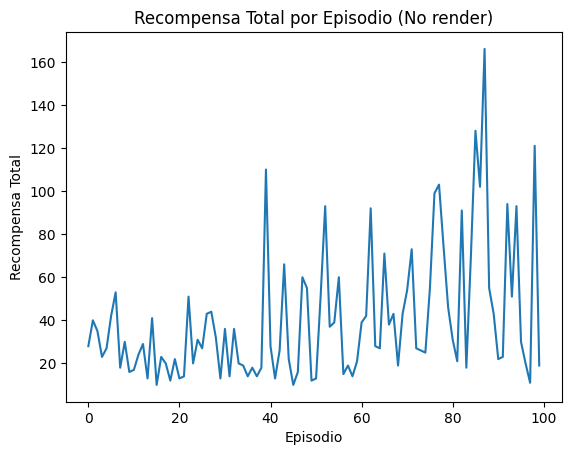

In [10]:
# Sin renderizacion

env = gym.make('CartPole-v1')

num_episodes = 100

batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
target_update_frequency = 10


episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()

    state, _ = state


    state = np.array(state, dtype=np.float32) 
    state = state.reshape((1, -1))

    total_reward = 0
    done = False
    state_count = 0

    while not done:

        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, input_shape])
        total_reward += reward

        experience_replay.append((state, action, reward, next_state, done))

        state = next_state

        if len(experience_replay) >= batch_size:
            states, actions, rewards, next_states, dones = experience_replay_sample(batch_size)

            states = np.vstack(states)

            target_values = online_model.predict(states)

            next_states = np.vstack(next_states)

            target_next_values = target_model.predict(next_states)
            max_target_values = np.max(target_next_values, axis=1)

            for i in range(batch_size):
                if dones[i]:
                    target_values[i][actions[i]] = rewards[i]
                else:
                    target_values[i][actions[i]] = rewards[i] + gamma * max_target_values[i]

            online_model.fit(states, target_values, epochs=1, verbose=0)

        if episode % target_update_frequency == 0:
            target_model.set_weights(online_model.get_weights())

    if epsilon > epsilon_min:
        print("im in")
        epsilon *= epsilon_decay

    print(f"Episode {episode}: Total Reward: {total_reward}")
    episode_rewards.append(total_reward)

env.close()

plt.plot(episode_rewards)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Recompensa Total por Episodio (No render)")
plt.show()


### 11. Fine-Tuning
Experimente con diferentes hiperparámetros, arquitecturas y estrategias de entrenamiento
para mejorar el desempeño del agente.

Valdría la pena agregar los siguientes parámetros:

In [ ]:
learning_rate = 0.001

num_episodes = 500
batch_size = 128
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.1
target_update_frequency = 20

### 12. Notas adicionales
Tenga en cuenta que los tiempos de entrenamiento pueden variar y puede ajustar la
frecuencia de actualización de la red de destino según los requisitos específicos de su tarea.

## Task 2 - Teoría
Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en
Deep Reinforcement Learning

1. Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) es un algoritmo introducido por OpenAi en 2017 con el fin de implementar el aprendizaje por refuerzo. Estos algoritmos son policy gradient methods (métodos de gradiente de políticas) lo que significa que en vez de asignarle valor a una pareja de estado-acción, estas buscan en un espacio de políticas. Tienen los beneficios de un TRPO, pero son más simples de implementar, más generales y tienen una mejor complejidad de prueba. 

2. Deep Deterministic Policy Gradients (DDPG)

Es un algoritmo que de forma confurrente aprende una Q-function y una política. Utiliza datos de off-policy y la ecuación de Bellman para aprender la Q-function y usa esa función para aprender la política.

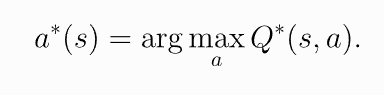

3. Trust Region Policy Optimization (TRPO)

Similar a policy gradient methods, este algoritmo es escalable y efectivo para optimizar políticas grandes (con miles de parámetros) no lineales como una red neuronal. Este algoritmo puede ser utilizado en ambientes con espacios de acción tanto discretos como continuos. Es posible paralelizar con MPI. TRPO tiene 2 variantes, la primera, *single-path* method puede ser aplicada en un set model-free, mietnras que la segunda, *vine* requiere que el sistema sea recuperado en ciertos estados particulares solamente posible en una simulación.

4. Asynchronous Advantage Actor-Critic (A3C)

Es un algorimto de aprendizaje reforzado que permite a los agentes aprender las acciones más óptimas en ambientes complejos. Este algoritmo fue desarrollado por Google's DeepMind. Este algoritmo tiene este nombre porque, primero, y a diferencia de otros algorimtos populares de aprendizaje reforzado, este algorimto utiliza múltiples agentes en un mismo ambiente. Cada agente tiene su propia red de parámetros y copia del ambiente, y cada uno interactua con su ambiente de manera asíncrona, aprendiendo con cada interacción controlada por una red global. También se le llama Arctor-critic porque cada agente de aprendizaje usa el valor de la función de valor para actualizar la función de política óptima


## Referencias
- John Schulman et al. (s.f.), Trust Region Policy Optimization, recuperado de: https://arxiv.org/pdf/1502.05477.pdf
- Wikipedia (2023), Proximal Policy Optimization, recuperado de: https://en.wikipedia.org/wiki/Proximal_Policy_Optimization#References
- OpenAI (s.f.), "Trust Region Policy Optimization", recuperado de: https://spinningup.openai.com/en/latest/algorithms/trpo.html
- OpenAI (s.f.), "Deep Deterministic Policy Gradient", recuperado de: https://spinningup.openai.com/en/latest/algorithms/ddpg.html
- AlindGupta (2023), "Asynchronous advantage actor critic, recuperado de Geeksforgeeks: https://www.geeksforgeeks.org/asynchronous-advantage-actor-critic-a3c-algorithm/